# KST-ML

## Know Sure Thing based Machine Learning Strategy for Predicting Stock Trading Signals

Arjun Singh Saud, Subarna Shakya

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 5]
plt.style.use('fivethirtyeight')

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [6]:
! which python

/home/julien/Devs/Finance/Experiments/KST-ML/venv/bin/python


### Data fetch

In [139]:
import yfinance as yf
ticker = yf.Ticker('SCC')
quotes = ticker.history(start='2011-01-10', end='2021-09-30')
quotes

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2011-01-10,1354.877809,1354.877809,1334.443185,1336.920166,142,0.0,0.0
2011-01-11,1331.347141,1344.350940,1330.727895,1339.397095,73,0.0,0.0
2011-01-12,1331.347185,1334.443294,1322.058740,1331.966431,83,0.0,0.0
2011-01-13,1327.012741,1337.539678,1325.774250,1333.205078,95,0.0,0.0
2011-01-14,1336.301011,1336.301011,1317.724121,1317.724121,103,0.0,0.0
...,...,...,...,...,...,...,...
2021-09-23,18.299999,18.299999,17.959999,18.080000,1300,0.0,0.0
2021-09-24,18.100000,18.139999,18.020000,18.020000,750,0.0,0.0
2021-09-27,18.100000,18.100000,17.920000,18.000000,900,0.0,0.0


### Technical indicators

In [140]:
from pandas import Series

In [141]:
from curses import window


def ROC(price: pd.Series, period: int=1) -> pd.Series:
    """ ROC: Rate of Change"""
    return price.rolling(window=period).apply(lambda x: x.iloc[-1]/x.iloc[0] if len(x) == period else 0)

def SMA(price: pd.Series, period=1):
    """SMA: Simple Moving Average"""
    return price.rolling(window=period).apply(lambda x: x.mean())

def KST(price: pd.Series, target_horizon: int=3) -> pd.Series:
    kst = SMA(ROC(price, 10), period=10) + \
        SMA(ROC(price, 15), period=10) * 2 + \
        SMA(ROC(price, 20), period=10) * 3 + \
        SMA(ROC(price, 30), period=15) * 4

    kst_s = SMA(kst, period = 9)

    delta = kst - kst_s
    signal = delta * 0

    last_state = np.sign(delta.iloc[0])
    for i in range(1, signal.shape[0]):
        cur_state = np.sign(delta.iloc[i])
        if cur_state != last_state:
            signal.iloc[i] = cur_state
        last_state = cur_state

    start = np.argmin(pd.isna(signal)) + 1

    target = signal * 0
    for i in range(start, target.shape[0] - target_horizon):
        if signal.iloc[i] != 0:
            target.iloc[i:i+target_horizon] = signal.iloc[i]
    
    return kst, kst_s, signal, target, start



In [142]:
price = quotes.Close

In [143]:
kst, kst_s, signal, target, start = KST(price)

In [144]:
buy_prices = (signal == 1)*price
sell_prices = (signal == -1)*price

buy_targets = (target == 1)*price
sell_targets = (target == -1)*price

In [159]:
def trade_signal(price, signal, start=0, equity=1e4, allow_long=True, allow_short=False):    
    """execute signal over price"""
    trades = []
    base_trade = {'open_idx': None, 'open_price': None, 'size': None, 'close_idx': None, 'close_price': None}
    trade = None
    for i in range(start, signal.shape[0]):
        if signal[i] == 1:
            if trade is None:
                if allow_long is True:
                    trade = {**base_trade, 'open_idx': price.index[i], 'open_price': price.iloc[i], 'size': 1}
            elif trade.get('size') < 0:
                # close
                trade['close_idx'] = price.index[i]
                trade['close_price'] = price.iloc[i]
                trades.append(trade)
                trade = None
                # and reverse
                if allow_long is True:
                    trade = {**base_trade, 'open_idx': price.index[i], 'open_price': price.iloc[i], 'size': 1}
            else:
                pass
        elif signal[i] == -1:
            if trade is None: 
                if allow_short is True:
                   trade = {**base_trade, 'open_idx': price.index[i], 'open_price': price.iloc[i], 'size': -1}
            elif trade.get('size') > 0:
                # close
                trade['close_idx'] = price.index[i]
                trade['close_price'] = price.iloc[i]
                trades.append(trade)
                trade = None
                # and reverse
                if allow_short is True:
                    trade = {**base_trade, 'open_idx': price.index[i], 'open_price': price.iloc[i], 'size': -1}
            else:
                pass
        else:
            pass
    if trade is not None:
        pass # simple discard

    trades = pd.DataFrame(data=trades)
    trades['ret'] = trades['close_price']/trades['open_price']

    # Todo: compute equity

    return trades

In [164]:
trades = trade_signal(price, signal, start=start, equity=1e4, allow_long=True, allow_short=False)

In [165]:
(trades.ret.mean() - 1)*100

-2.3015902669940136

In [166]:
(trades.ret-1>0).sum()/trades.shape[0]

0.2638888888888889

In [167]:
(trades.ret-1).mean() / (trades.ret-1).std()

-0.3172221727329894

In [168]:
(trades.ret).mean() / (trades.ret).std()

13.465516539805

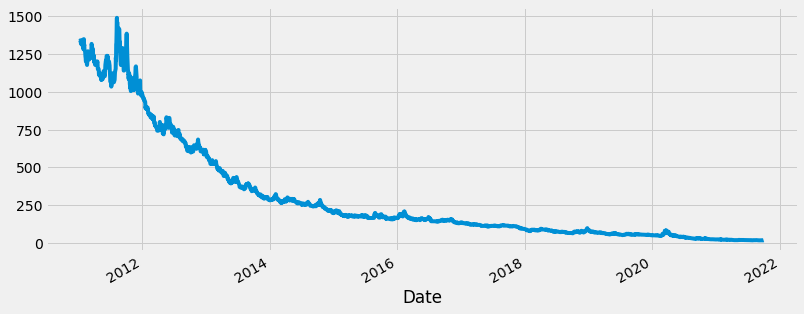

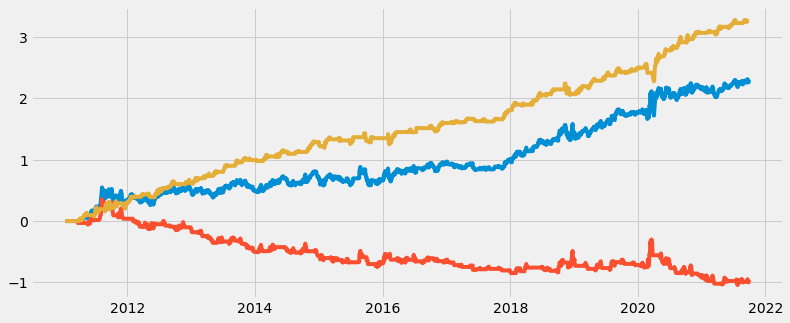

In [169]:
price.plot()
plt.show()

ret = np.log1p(price.pct_change())
simple_pos = np.sign(kst - kst_s).iloc[:-1]
simple_pos_buy = (np.sign(kst - kst_s).iloc[:-1] == 1) * 1
simple_pos_sell = (np.sign(kst - kst_s).iloc[:-1] == -1) * -1

simple_ret = simple_pos * ret
simple_ret_buy = simple_pos_buy * ret
simple_ret_sell = simple_pos_sell * ret
plt.plot(simple_ret.cumsum())
plt.plot(simple_ret_buy.cumsum())
plt.plot(simple_ret_sell.cumsum())


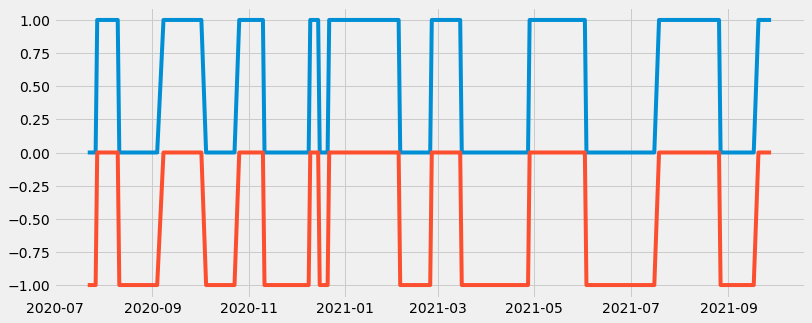

In [170]:
plt.plot(simple_pos_buy.iloc[u1:])
plt.plot(simple_pos_sell.iloc[u1:])

In [153]:
sr = lambda ret: ret.mean() / ret.std()
simple_sr = sr(simple_ret)
simple_sr_buy = sr(simple_ret_buy)
simple_sr_sell = sr(simple_ret_sell)

simple_sr, simple_sr_buy, simple_sr_sell, sr(ret)

(0.0417090104723363,
 -0.02160849063069804,
 0.09677495145534414,
 -0.07629087787008468)

In [154]:
# ARR:
100 * (np.power(1 + simple_ret.mean(), simple_ret.shape[0]/252)-1)

0.934683026706784

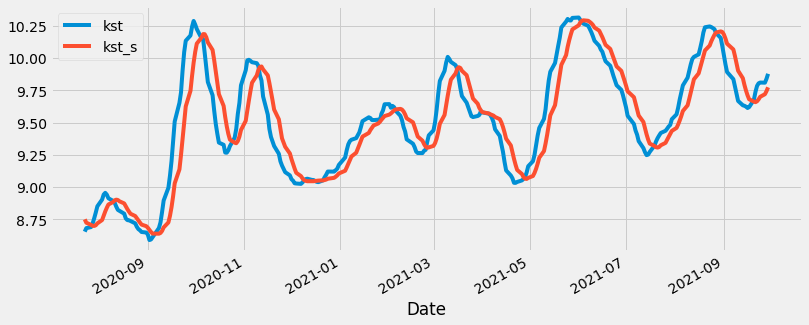

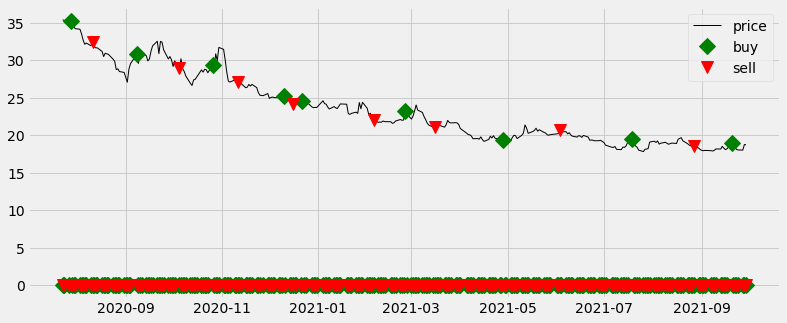

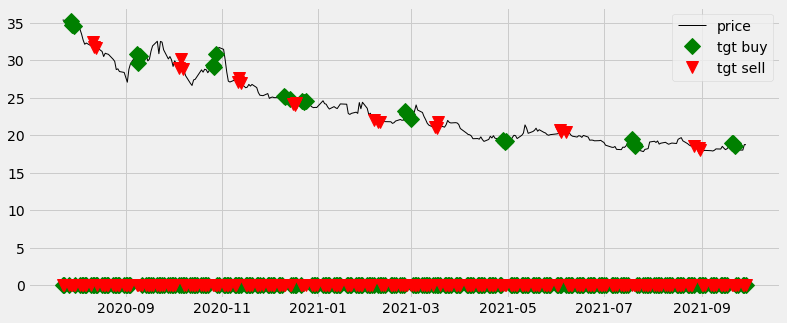

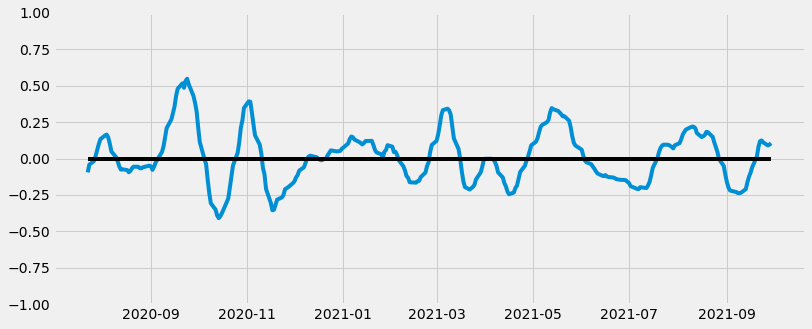

In [156]:

u1 = -300

kst.iloc[u1:].plot()
kst_s.iloc[u1:].plot()
plt.legend(['kst', 'kst_s'])
plt.show()

plt.plot(price.iloc[u1:], 'k-', linewidth=1)
plt.plot(buy_prices.iloc[u1:], 'gD', markersize=12)
plt.plot(sell_prices.iloc[u1:], 'rv', markersize=12)
plt.legend(['price', 'buy', 'sell'])
# plt.ylim((40,70))
plt.show()

plt.plot(price.iloc[u1:], 'k-', linewidth=1)
plt.plot(buy_targets.iloc[u1:], 'gD', markersize=12)
plt.plot(sell_targets.iloc[u1:], 'rv', markersize=12)
plt.legend(['price', 'tgt buy', 'tgt sell'])
# plt.ylim((40,70))
plt.show()


plt.plot((kst - kst_s).iloc[u1:])
plt.hlines(0, kst.iloc[u1:].index[0], kst.iloc[u1:].index[-1], colors='black')
plt.ylim(-1, 1)
plt.show()

In [72]:
target.iloc[-40:-20]

Date
2021-08-04   -0.0
2021-08-05   -0.0
2021-08-06   -0.0
2021-08-09   -0.0
2021-08-10    1.0
2021-08-11    1.0
2021-08-12    1.0
2021-08-13    0.0
2021-08-16    0.0
2021-08-17    0.0
2021-08-18    0.0
2021-08-19    0.0
2021-08-20    0.0
2021-08-23    0.0
2021-08-24    0.0
2021-08-25    0.0
2021-08-26    0.0
2021-08-27    0.0
2021-08-30    0.0
2021-08-31    0.0
Name: Close, dtype: float64